<a href="https://colab.research.google.com/github/MiguelALopez1/BirdCallClassifier/blob/main/TheRealBirdCallClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas torch torchaudio datasets evaluate scikit-learn huggingface_hub tqdm mlflow
!pip install transformers accelerate -U

In [2]:
from pathlib import Path
import pandas as pd

# Define a function to load bird sound data from a specified directory.
def load_data():
    # Initialize empty lists to store file paths and corresponding labels.
    file_list = []  # To store file paths
    label_list = []  # To store labels

    # Iterate through all the .mp3 files in the specified directory and its subdirectories.
    for file in Path('/content/drive/MyDrive/labeledData').glob('*/*.mp3'):
        # Extract the label from the file path by splitting the path and retrieving the second-to-last part.
        # The label is assumed to be the second-to-last part, separated by '/' and '_' characters.
        label = str(file).split('/')[-2].split('_')[0]

        # Append the current file path to the file_list and its corresponding label to the label_list.
        file_list.append(file)
        label_list.append(label)

    # Create an empty DataFrame to organize the data.
    dd = pd.DataFrame()

    # Create two columns in the DataFrame: 'file' to store file paths and 'label' to store labels.
    dd['file'] = file_list
    dd['label'] = label_list

    # Return the DataFrame containing the file paths and labels.
    return dd

# Load the data into a DataFrame
df = load_data()  # Assuming there's a function called load_data() that loads data into 'df'.

In [3]:
MIN_RECORDS_PER_LABEL = 25

# Calculate label counts
label_counts = df['label'].value_counts()

# Identify undersampled labels
undersampled_labels = label_counts[label_counts < MIN_RECORDS_PER_LABEL].index

# Remove rows with undersampled labels
df = df[~df['label'].isin(undersampled_labels)]

# Print the shape of the resulting DataFrame
print(df.shape)

(251, 2)


In [4]:
from tqdm import tqdm
import torchaudio
import librosa

# Define the resampling rate in Hertz (Hz) for audio data
RATE_HZ = 16000

# Define the maximum audio interval length to consider in seconds
MAX_SECONDS = 10

# Calculate the maximum audio interval length in samples by multiplying the rate and seconds
MAX_LENGTH = RATE_HZ * MAX_SECONDS

# Function to compute the custom spectrogram features
def compute_custom_spectrogram(file_path):
    y, sr = librosa.load(file_path)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    y_harm, y_perc = librosa.effects.hpss(y)
    S_harm = librosa.feature.melspectrogram(y=y_harm, sr=sr, n_mels=128, fmax=8000)
    S_harm_dB = librosa.power_to_db(S_harm, ref=np.max)
    return S_dB, S_harm_dB

# Split files by chunks with == MAX_LENGTH size
def split_audio(file):
    try:
        # Load the audio file using torchaudio and get its sample rate.
        audio, rate = torchaudio.load(str(file))

        # Calculate the number of segments based on the MAX_LENGTH
        num_segments = (len(audio[0]) // MAX_LENGTH)  # Floor division to get segments

        # Create an empty list to store segmented audio data
        segmented_audio = []

        # Split the audio into segments
        for i in range(num_segments):
            start = i * MAX_LENGTH
            end = min((i + 1) * MAX_LENGTH, len(audio[0]))
            segment = audio[0][start:end]

            # Create a transformation to resample the audio to a specified sample rate (RATE_HZ).
            transform = torchaudio.transforms.Resample(rate, RATE_HZ)
            segment = transform(segment).squeeze(0).numpy().reshape(-1)

            segmented_audio.append(segment)

        # Create a DataFrame from the segmented audio
        df_segments = pd.DataFrame({'audio': segmented_audio})

        return df_segments

    except Exception as e:
        # If an exception occurs (e.g., file not found), return nothing
        print(f"Error processing file: {e}")
        return None

df_list = []
for input_file, input_label in tqdm(zip(df['file'].values, df['label'].values)):
    resulting_df = split_audio(input_file)
    if resulting_df is not None:
        resulting_df['label'] = input_label
        df_list.append(resulting_df)
df = pd.concat(df_list, axis=0)
# Selecting rows in the DataFrame where the 'audio' column is not null (contains non-missing values).
df = df[~df['audio'].isnull()]

6it [00:01,  4.65it/s]

Error processing file: Failed to open the input "/content/drive/MyDrive/labeledData/NorthernMockingbird/NorthernMockingbird46.mp3" (Invalid argument).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x57 (0x7b6a34f7a897 in /usr/local/lib/python3.10/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7b6a34f2ab25 in /usr/local/lib/python3.10/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42334 (0x7b6a34ec0334 in /usr/local/lib/python3.10/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::optional<std::map<std::string, std::string, std::less<std::string>, std::allocator<std::pair<std::

251it [00:25, 10.01it/s]


In [5]:
from datasets import Dataset, ClassLabel

# Define the fraction of records to be used for testing data
TEST_SIZE = 0.2

# Removing the 'file' column from the DataFrame 'df'
if 'file' in df.columns:
    df = df.drop(['file'], axis=1)

# Create a dataset from the Pandas DataFrame 'df'
dataset = Dataset.from_pandas(df)

# Create a list of unique labels
labels_list = sorted(list(df['label'].unique()))

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

# Creating classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

# Casting label column to ClassLabel Object
dataset = dataset.cast_column('label', ClassLabels)

# Check the class distribution
class_distribution = df['label'].value_counts()
classes_with_one_member = class_distribution[class_distribution == 1]

if not classes_with_one_member.empty:
    # Print classes with only one member
    print("Classes with only one member:")
    print(classes_with_one_member)

    # Remove rows with classes that have only one member
    df = df[~df['label'].isin(classes_with_one_member.index)]

# Splitting the dataset into training and testing sets using the predefined train/test split ratio.
dataset = dataset.train_test_split(test_size=TEST_SIZE, shuffle=True, stratify_by_column="label")


# Deleting the DataFrame 'df'
del df

# Performing garbage collection to free up memory
import gc
gc.collect()


Mapping of IDs to Labels: {0: 'AmericanOystercatcher', 1: 'Bananaquit', 2: 'NorthernMockingbird', 3: 'White-wingedDove'} 

Mapping of Labels to IDs: {'AmericanOystercatcher': 0, 'Bananaquit': 1, 'NorthernMockingbird': 2, 'White-wingedDove': 3}


Map:   0%|          | 0/2983 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2983 [00:00<?, ? examples/s]

212

In [6]:
import numpy as np
import evaluate
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments, Trainer

# Specify the pre-trained model you want to use.
model_str = "dima806/bird_sounds_classification"

# Create an instance of the feature extractor for audio.
feature_extractor = AutoFeatureExtractor.from_pretrained(model_str)

# Create an instance of the audio classification model.
# The 'num_labels' parameter is set to the number of labels in your 'labels_list'.
model = AutoModelForAudioClassification.from_pretrained(model_str, num_labels=len(labels_list), ignore_mismatched_sizes=True)

# Set the 'id2label' mapping in the model's configuration. This maps label IDs to human-readable labels.
model.config.id2label = id2label

# Calculate and print the number of trainable parameters in the model (in millions).
# This provides an estimate of the model's size.
print(model.num_parameters(only_trainable=True) / 1e6)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at dima806/bird_sounds_classification were not used when initializing Wav2Vec2ForSequenceClassification: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTrain

94.569604


In [7]:
# Define a preprocessing function for the dataset
def preprocess_function(batch):
    # Check if 'audio' column exists in the batch
    if 'audio' in batch:
        # Extract audio features from the input batch using the feature_extractor
        inputs = feature_extractor(batch['audio'], sampling_rate=RATE_HZ, max_length=MAX_LENGTH, truncation=True)

        # Extract and store only the 'input_values' component from the extracted features
        inputs['input_values'] = inputs['input_values'][0]

        return inputs
    else:
        # If 'audio' column does not exist, return None
        return None

# Apply the preprocess_function to the 'train' split of the dataset
dataset['train'] = dataset['train'].map(preprocess_function, batched=False)

# Remove the 'audio' column from the 'train' split
if 'audio' in dataset['train'].column_names:
    dataset['train'] = dataset['train'].remove_columns(['audio'])

# Apply the same preprocess_function to the 'test' split of the dataset
dataset['test'] = dataset['test'].map(preprocess_function, batched=False)

# Remove the 'audio' column from the 'test' split
if 'audio' in dataset['test'].column_names:
    dataset['test'] = dataset['test'].remove_columns(['audio'])



Map:   0%|          | 0/2386 [00:00<?, ? examples/s]

Map:   0%|          | 0/597 [00:00<?, ? examples/s]

In [8]:
# Load the "accuracy" metric using the evaluate.load() function.
accuracy = evaluate.load("accuracy")

# Define a function to compute evaluation metrics, which takes eval_pred as input.
def compute_metrics(eval_pred):
    # Extract the model's predictions from eval_pred.
    predictions = eval_pred.predictions

    # Apply the softmax function to convert prediction scores into probabilities.
    predictions = np.exp(predictions) / np.exp(predictions).sum(axis=1, keepdims=True)

    # Extract the true label IDs from eval_pred.
    label_ids = eval_pred.label_ids

    # Calculate accuracy using the loaded accuracy metric by comparing predicted classes
    # (argmax of probabilities) with the true label IDs.
    acc_score = accuracy.compute(predictions=predictions.argmax(axis=1), references=label_ids)['accuracy']

    # Return the computed accuracy as a dictionary with a key "accuracy."
    return {
        "accuracy": acc_score
    }

In [9]:
from transformers import TrainingArguments, Trainer
import torch

# Define the batch size for training data
batch_size = 4

# Define the number of warmup steps for learning rate scheduling
warmup_steps = 50

# Define the weight decay for regularization
weight_decay = 0.02

# Define the number of training epochs
num_train_epochs = 25

# Define the name for the model directory
model_name = "bird_sounds_classification"

# Define the Google Drive directory to save the model
gdrive_dir = '/content/drive/MyDrive/models/'

# Create TrainingArguments object to configure the training process
training_args = TrainingArguments(
    output_dir=model_name,  # Directory to save the model
    logging_dir='./logs',  # Directory for training logs
    num_train_epochs=num_train_epochs,  # Number of training epochs
    per_device_train_batch_size=batch_size,  # Batch size for training
    per_device_eval_batch_size=batch_size,  # Batch size for evaluation
    learning_rate=5e-6,  # Learning rate for training
    logging_strategy='steps',  # Log at specified steps
    logging_first_step=True,  # Log the first step
    load_best_model_at_end=True,  # Load the best model at the end of training
    logging_steps=1,  # Log every step
    evaluation_strategy='epoch',  # Evaluate at the end of each epoch
    warmup_steps=warmup_steps,  # Number of warmup steps for learning rate
    weight_decay=weight_decay,  # Weight decay for regularization
    eval_steps=1,  # Evaluate every step
    gradient_accumulation_steps=1,  # Number of gradient accumulation steps
    gradient_checkpointing=True,  # Enable gradient checkpointing
    save_strategy='epoch',  # Save model at the end of each epoch
    save_total_limit=1,  # Limit the number of saved checkpoints
    report_to="mlflow",  # Log training information to MLflow
)

# Create a Trainer object to manage the training process
trainer = Trainer(
    model=model,  # The model to be trained
    args=training_args,  # Training configuration
    train_dataset=dataset['train'],  # Training dataset
    eval_dataset=dataset['test'],  # Evaluation dataset
    tokenizer=feature_extractor,  # Tokenizer
    compute_metrics=compute_metrics,  # Compute metrics
)

# Function to save model weights to Google Drive
def save_model_to_gdrive(trainer, model_name, gdrive_dir):
    # Save the model
    trainer.save_model(model_name)
    # Copy the model directory to Google Drive
    model_path = Path(model_name)
    gdrive_path = Path(gdrive_dir) / model_name
    if not gdrive_path.exists():
        gdrive_path.mkdir(parents=True)
    for file in model_path.iterdir():
        target_file = gdrive_path / file.name
        if file.is_file():
            torch.save(torch.load(file, map_location='cpu'), target_file)
    print(f"Model saved to {gdrive_path}")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [10]:
# Evaluate the trained model's performance on a validation or test dataset.
# This step is crucial for assessing how well the model generalizes to unseen data.

# The `trainer.evaluate()` method typically computes metrics such as accuracy, loss, F1-score,
# or any other relevant metrics specified during model training.

# It uses the validation or test dataset specified during training to make predictions
# and then compares these predictions to the actual target values to calculate the metrics.

# The results of this evaluation can provide insights into the model's performance and help
# identify areas for improvement or optimization.
trainer.evaluate()

# This line of code initiates the training process for the model using the 'trainer' object.

trainer.train()

# Evaluate the model using the trainer's built-in evaluation function.
trainer.evaluate()

# Save the model weights to Google Drive
save_model_to_gdrive(trainer, model_name, gdrive_dir)

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.110700,0.462080,0.882747
2,0.675100,0.444382,0.901173
3,0.027100,0.389189,0.917923
4,0.005400,0.265042,0.946399
5,0.008600,0.245899,0.954774
6,0.006200,0.293356,0.948074
7,0.002400,0.308127,0.949749
8,0.001400,0.329265,0.951424
9,0.002500,0.288801,0.959799
10,0.000600,0.256314,0.964824


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant paramet

UnpicklingError: invalid load key, '{'.

In [11]:
import numpy as np
import evaluate
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments, Trainer

{'test_loss': 0.2301490604877472, 'test_accuracy': 0.964824120603015, 'test_runtime': 26.5273, 'test_samples_per_second': 22.505, 'test_steps_per_second': 5.655}
Accuracy: 0.9648
F1 Score: 0.9456


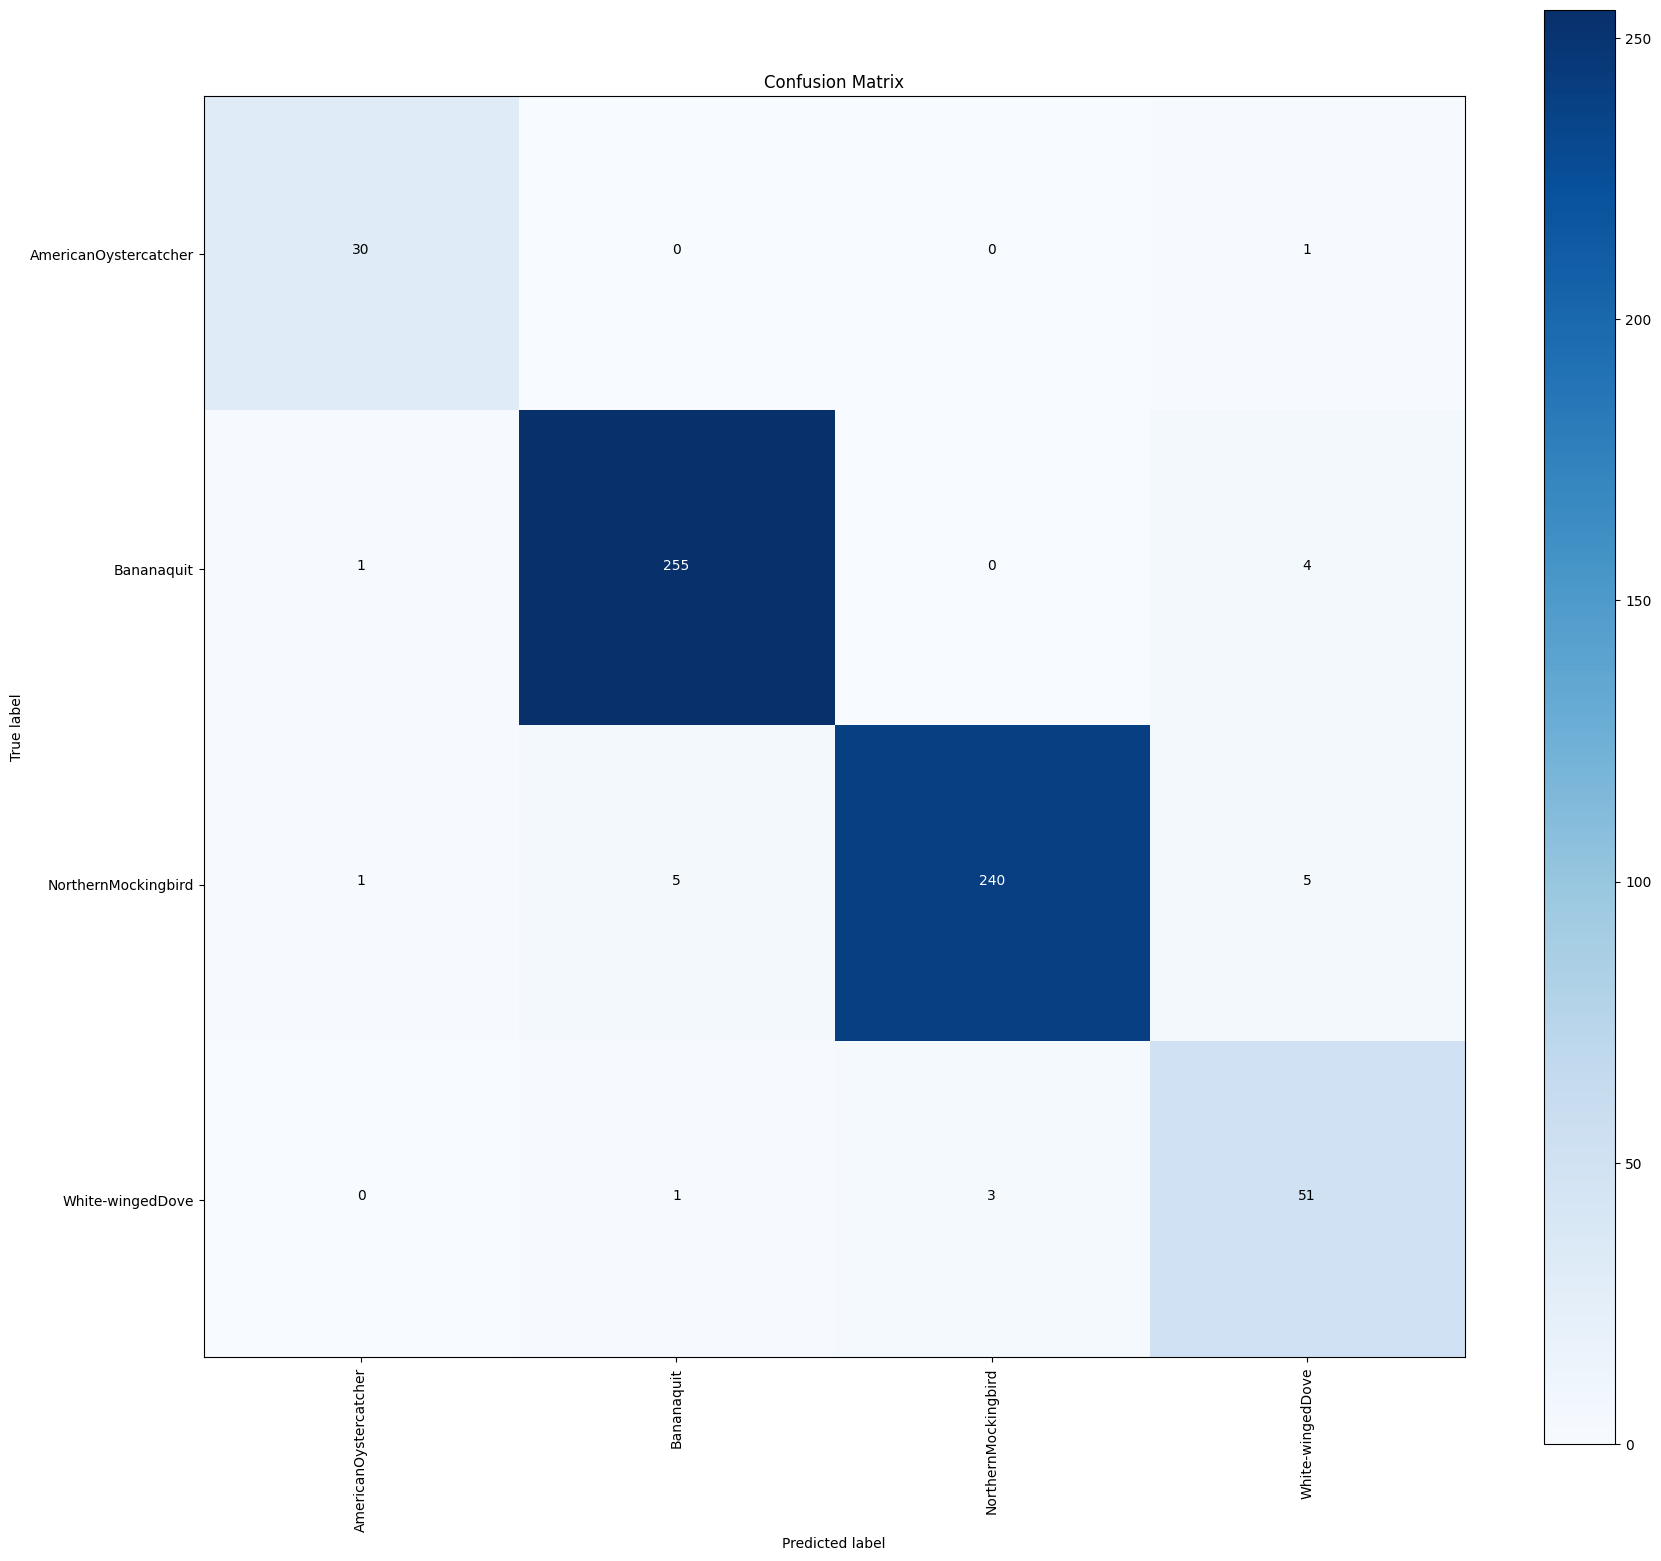


Classification report:

                       precision    recall  f1-score   support

AmericanOystercatcher     0.9375    0.9677    0.9524        31
           Bananaquit     0.9770    0.9808    0.9789       260
  NorthernMockingbird     0.9877    0.9562    0.9717       251
     White-wingedDove     0.8361    0.9273    0.8793        55

             accuracy                         0.9648       597
            macro avg     0.9346    0.9580    0.9456       597
         weighted avg     0.9664    0.9648    0.9653       597



In [13]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import itertools

# Use the trained 'trainer' to make predictions on the test dataset.
outputs = trainer.predict(dataset['test'])

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8), is_norm=True):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)

    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if is_norm:
        fmt = '.3f'
    else:
        fmt = '.0f'

    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()

    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a relatively small number of labels
if len(labels_list) <= 120:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred) # normalize='true'

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(18, 16), is_norm=False)

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))
